In [1]:
!git clone https://github.com/tomduyanh/Pneumonia-Diagnosis-via-Image-Classification.git

Cloning into 'Pneumonia-Diagnosis-via-Image-Classification'...
remote: Enumerating objects: 5873, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 5873 (delta 10), reused 14 (delta 2), pack-reused 5840 (from 2)
Receiving objects: 100% (5873/5873), 1.19 GiB | 13.39 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (6138/6138), done.


In [2]:
import os
data_path = os.path.join('Pneumonia-Diagnosis-via-Image-Classification', 'data')

In [3]:
os.makedirs('/content/data/train', exist_ok = True)
os.makedirs('/content/data/test', exist_ok = True)
os.makedirs('/content/data/val', exist_ok = True)

In [4]:
import shutil

def move(src_dir, dst_dir):
  for f in os.listdir(src_dir):
    shutil.move(os.path.join(src_dir, f), dst_dir)

move(os.path.join(data_path, 'train'), '/content/data/train/')
move(os.path.join(data_path, 'test'), '/content/data/test')
move(os.path.join(data_path, 'val'), '/content/data/val')

In [5]:
print(len(os.listdir('/content/data/val/PNEUMONIA')))
print(len(os.listdir('/content/data/test/NORMAL')))

427
182


In [6]:
import numpy as np
from PIL import Image
def image_to_array(img_paths):
  img_arrays = []
  for img_path in img_paths:
    img = Image.open(img_path).convert('L').resize((128, 128))
    img_arrays.append(np.array(img))
  return np.array(img_arrays)

In [7]:
train_normal_arrays = image_to_array(os.path.join('/content/data/train/NORMAL', f) for f in os.listdir('/content/data/train/NORMAL'))
train_pneumonia_arrays = image_to_array(os.path.join('/content/data/train/PNEUMONIA', f) for f in os.listdir('/content/data/train/PNEUMONIA'))
test_normal_arrays = image_to_array(os.path.join('/content/data/test/NORMAL', f) for f in os.listdir('/content/data/test/NORMAL'))
test_pneumonia_arrays = image_to_array(os.path.join('/content/data/test/PNEUMONIA', f) for f in os.listdir('/content/data/test/PNEUMONIA'))
val_normal_arrays = image_to_array(os.path.join('/content/data/val/NORMAL', f) for f in os.listdir('/content/data/val/NORMAL'))
val_pneumonia_arrays = image_to_array(os.path.join('/content/data/val/PNEUMONIA', f) for f in os.listdir('/content/data/val/PNEUMONIA'))

In [8]:
train_normal_arrays.shape

(1455, 128, 128)

In [9]:
X_train = np.concatenate((train_normal_arrays, train_pneumonia_arrays), axis=0)
y_train = np.array([0] * len(train_normal_arrays) + [1] * len(train_pneumonia_arrays))
X_val = np.concatenate((val_normal_arrays, val_pneumonia_arrays), axis=0)
y_val = np.array([0] * len(val_normal_arrays) + [1] * len(val_pneumonia_arrays))
X_test = np.concatenate((test_normal_arrays, test_pneumonia_arrays), axis=0)
y_test = np.array([0] * len(test_normal_arrays) + [1] * len(test_pneumonia_arrays))

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [11]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.long)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.long)

In [12]:
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


print(X_train.shape)
print(X_val.shape)

torch.Size([4912, 1, 128, 128])
torch.Size([609, 1, 128, 128])


In [13]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

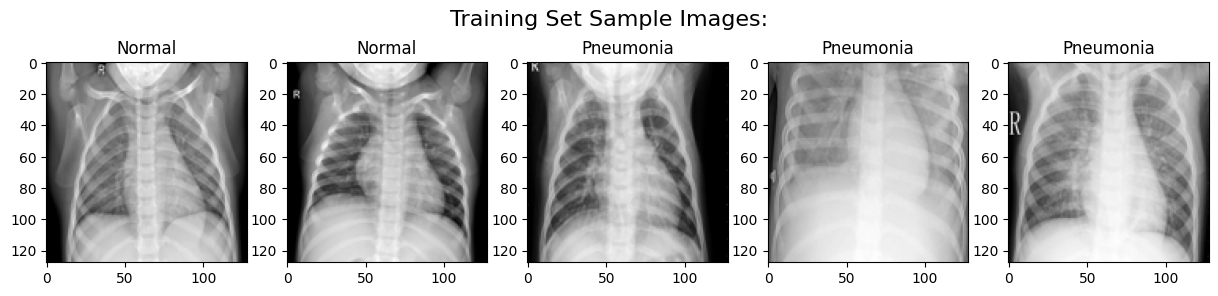

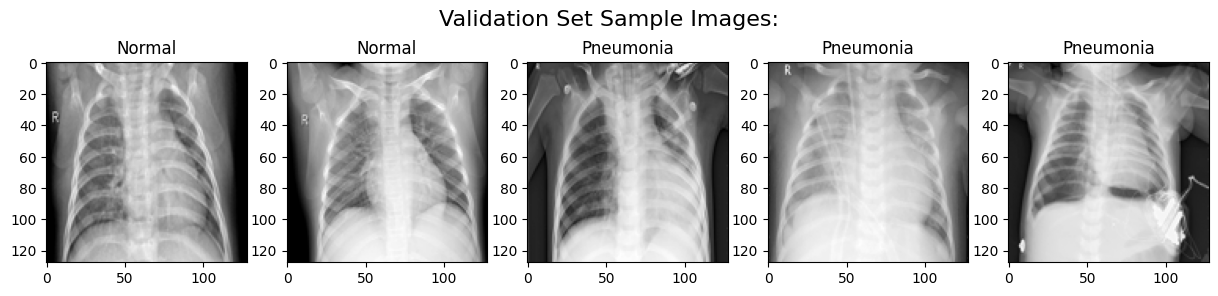

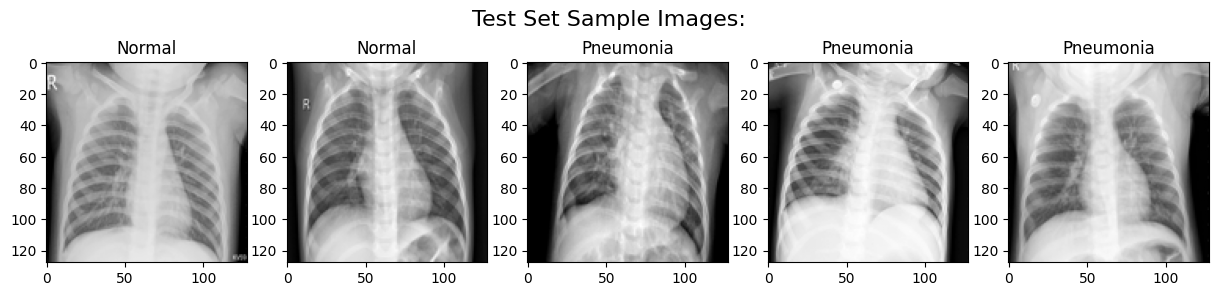

In [14]:
import matplotlib.pyplot as plt
import random

def plot_sample_images(dataset, title):
  plt.figure(figsize=(15, 5))
  plt.suptitle(title, fontsize=16, y=0.8)
  num_images_to_show = 5

  normal_indices = [i for i, label in enumerate(dataset.tensors[1]) if label == 0]
  pneumonia_indices = [i for i, label in enumerate(dataset.tensors[1]) if label == 1]

  plot_indices = random.sample(normal_indices, num_images_to_show // 2) + random.sample(pneumonia_indices, num_images_to_show - num_images_to_show // 2)

  for i, id in enumerate(plot_indices):
    img = dataset.tensors[0][id].squeeze().numpy()
    label = dataset.tensors[1][id].item()
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Normal' if label == 0 else 'Pneumonia')
    plt.axis('on')
  plt.show()

plot_sample_images(train_dataset, 'Training Set Sample Images:')
plot_sample_images(val_dataset, 'Validation Set Sample Images:')
plot_sample_images(test_dataset, 'Test Set Sample Images:')

In [15]:
class PneumoniaDiagnosis(nn.Module):
  def __init__(self):
    super(PneumoniaDiagnosis, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1_input_features = 256 * 8 * 8
    self.fc1 = nn.Linear(self.fc1_input_features, 512)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.pool(F.relu(self.bn4(self.conv4(x))))
    x = x.view(-1, self.fc1_input_features)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PneumoniaDiagnosis().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
epochs = 20
best_val_loss = float('inf')
train_losses = []
val_accuracies = []

for epoch in range(epochs):
  model.train()
  total_loss = 0

  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    output = model(X_batch)

    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_losses.append(total_loss/len(train_loader))

  if(total_loss < best_val_loss):
    best_val_loss = total_loss
    torch.save(model.state_dict(), 'best_model.pth')
  print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

  model.eval()
  total_correct = 0
  total_samples = 0

  with torch.no_grad():
    for X_batch, y_batch in val_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      output = model(X_batch)
      _, predicted = torch.max(output, 1)

      total_samples += y_batch.size(0)
      total_correct += (predicted == y_batch).sum().item()

  accuracy = 100 * total_correct / total_samples
  val_accuracies.append(accuracy)
  print(f'Val Accuracy: {accuracy}%')

Epoch 1/20, Loss: 0.5961134045614631
Val Accuracy: 94.08866995073892%
Epoch 2/20, Loss: 0.16222793914909875
Val Accuracy: 90.9688013136289%
Epoch 3/20, Loss: 0.13423702816853855
Val Accuracy: 88.01313628899835%
Epoch 4/20, Loss: 0.13157175244860253
Val Accuracy: 94.41707717569787%
Epoch 5/20, Loss: 0.11971450542015108
Val Accuracy: 90.311986863711%
Epoch 6/20, Loss: 0.10308822496588547
Val Accuracy: 93.5960591133005%
Epoch 7/20, Loss: 0.10455540912422388
Val Accuracy: 94.25287356321839%
Epoch 8/20, Loss: 0.1032633789234444
Val Accuracy: 90.80459770114942%
Epoch 9/20, Loss: 0.09152836598721999
Val Accuracy: 90.64039408866995%
Epoch 10/20, Loss: 0.08569270722619439
Val Accuracy: 89.32676518883416%
Epoch 11/20, Loss: 0.08292206875978389
Val Accuracy: 88.01313628899835%
Epoch 12/20, Loss: 0.086088099962179
Val Accuracy: 93.26765188834155%
Epoch 13/20, Loss: 0.07341865258587693
Val Accuracy: 95.73070607553366%
Epoch 14/20, Loss: 0.06427665175673515
Val Accuracy: 91.46141215106732%
Epoch 15/

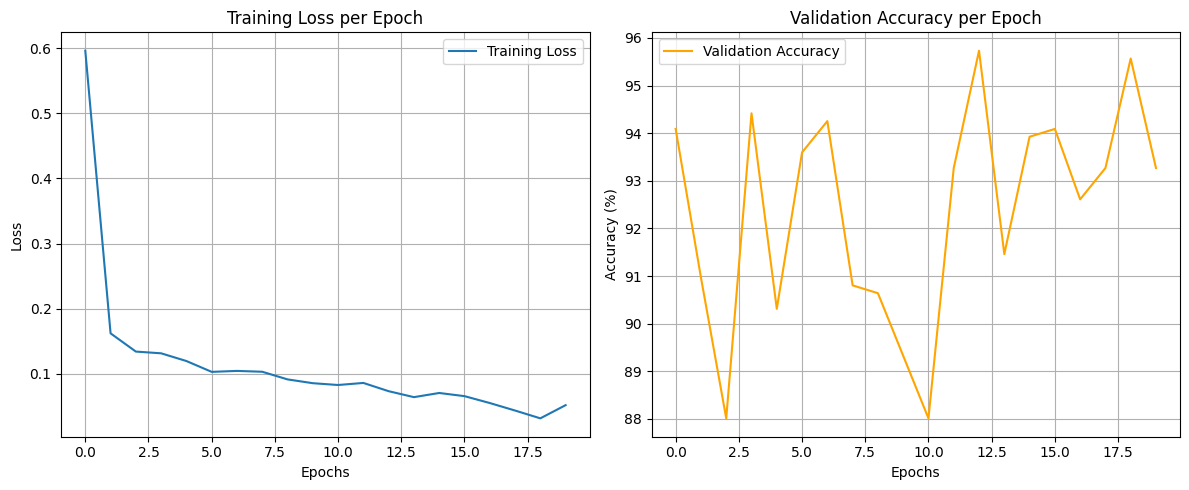

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.to(device)

PneumoniaDiagnosis(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

with torch.no_grad():
  total_correct = 0
  total_samples = 0
  all_predicted = []
  all_y_batch = []
  for X_batch, y_batch in test_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    output = model(X_batch)
    _, predicted = torch.max(output, 1)

    total_samples += y_batch.size(0)
    total_correct += (predicted == y_batch).sum().item()
    all_predicted.extend(predicted.cpu().numpy())
    all_y_batch.extend(y_batch.cpu().numpy())


  accuracy = 100 * total_correct / total_samples
  cm = confusion_matrix(all_y_batch, all_predicted)
  report = classification_report(all_y_batch, all_predicted, output_dict=True)

  print(f'Test Accuracy: {accuracy}%')
  print(f'Confusion Matrix:\n', cm)

  print('Classification Metrics:')
  print(f'- Precision (Class 0 - Normal): {report["0"]["precision"]:.2f}')
  print(f'- Recall (Class 0 - Normal): {report["0"]["recall"]:.2f}')
  print(f'- F1-score (Class 0 - Normal): {report["0"]["f1-score"]:.2f}')
  print(f'- Precision (Class 1 - Pneumonia): {report["1"]["precision"]:.2f}')
  print(f'- Recall (Class 1 - Pneumonia): {report["1"]["recall"]:.2f}')
  print(f'- F1-score (Class 1 - Pneumonia): {report["1"]["f1-score"]:.2f}')

Test Accuracy: 94.09836065573771%
Confusion Matrix:
 [[149  33]
 [  3 425]]
Classification Metrics:
- Precision (Class 0 - Normal): 0.98
- Recall (Class 0 - Normal): 0.82
- F1-score (Class 0 - Normal): 0.89
- Precision (Class 1 - Pneumonia): 0.93
- Recall (Class 1 - Pneumonia): 0.99
- F1-score (Class 1 - Pneumonia): 0.96
